In [1]:
import numpy as np
import astropy
from astropy.io import fits
from matplotlib import pyplot
import pandas as pd
import plotting as my_plot
import os

import auxil_ML as aux
import dio3 as dio

In [2]:
if 1:
    import importlib
    importlib.reload(aux);


In [109]:
folder = '../SOM'
cat = '3FGL'
pop = 'AGN' #'PSR', 'AGN'
#pop = 'PSR'
quantity = 'Flux1000'
save_plots = 1

my_plot.setup_figure_pars()


alg0 = 'LR'
algs0 = ['RF', 'BDT', 'LR', 'NN']
algs = algs0 + [alg + '_O' for alg in algs0]

bins = np.linspace(-10.5, -6.5, 17)
binsc = (bins[1:] + bins[:-1])/2


In [110]:

#cat = '4FGL' # '3FGL', '4FGL'
if cat == '3FGL':
    fn_cat = '../PS_comparison/gll_psc_v16.fit' # the last release of 3FGL
else:
    #fn_cat = '../PS_comparison/gll_psc_v22.fit' # 4FGL release from 27 May 2020
    fn_cat = '../PS_comparison/gll_psc_v27.fit' # 4FGL_DR2


if cat == '4FGL':
    #cat_name = '4FGL'
    cat_name = '4FGL-DR2'
else:
    cat_name = cat
    
#fn_pcat = '%s/%s_catalog_newfeats.csv' % (folder, cat)
fn_pcat = '%s/%s_prob_catalog_3classes.csv' % (folder, cat_name)
#fn_pcat = '%s/%s_prob_catalog_3class.csv' % (folder, cat)


hdu_cat = fits.open(fn_cat)
pcat_fgl = pd.read_csv(fn_pcat, index_col='Source_Name_%s' % cat)

index = np.array(hdu_cat[1].data.field('Source_Name'), dtype=str)
data = {quantity:np.array(hdu_cat[1].data.field(quantity), dtype=float)}
df_fgl = pd.DataFrame(data=data, index=index)
df_fgl.index = [st.strip() for st in df_fgl.index]
df_fgl = df_fgl.loc[pcat_fgl.index]
if quantity == 'Flux1000':
    df_fgl = np.log10(df_fgl)

In [111]:
if 0:
    df = aux.hdu2df(hdu_cat[1])
    df['CLASS1']

In [112]:
# import 2-class histograms
# unassociated sources
unas_dNdS_2class = {}
if pop != 'OTHER':
    fn = 'data/section6_plots/%s_%s_unassoc.yaml' % (cat_name, pop)
    unas_dNdS_2class0 = dio.loaddict(fn)
    fn = 'data/section6_plots/%s_%s_unassoc_other.yaml' % (cat_name, pop)
    unas_dNdS_other_2class0 = dio.loaddict(fn)
    for key in unas_dNdS_2class0.keys():
        unas_dNdS_2class[key] = aux.h2cum(np.array(unas_dNdS_2class0[key]) - np.array(unas_dNdS_other_2class0[key]))
    unas_dNdS_2class['xs'] = np.array(unas_dNdS_2class0['xs'])
else:
    fn = 'data/section6_plots/%s_AGN_unassoc_other.yaml' % (cat_name)
    AGN_dct = dio.loaddict(fn)
    fn = 'data/section6_plots/%s_PSR_unassoc_other.yaml' % (cat_name)
    PSR_dct = dio.loaddict(fn)
    for key in unas_dNdS_2class0.keys():
        unas_dNdS_2class[key] = aux.h2cum(np.array(AGN_dct[key]) + np.array(PSR_dct[key]))
    unas_dNdS_2class['xs'] = np.array(AGN_dct['xs'])
    
# associated sources
assoc_dNdS_2class = {}
if pop != 'OTHER':
    fn = 'data/section6_plots/%s_%s_assoc.yaml' % (cat_name, pop)
    assoc_dNdS_2class0 = dio.loaddict(fn)
    fn = 'data/section6_plots/%s_%s_assoc_other.yaml' % (cat_name, pop)
    assoc_dNdS_other_2class0 = dio.loaddict(fn)
    for key in assoc_dNdS_2class0.keys():
        assoc_dNdS_2class[key] = aux.h2cum(np.array(assoc_dNdS_2class0[key]) - np.array(assoc_dNdS_other_2class0[key]))
    assoc_dNdS_2class['xs'] = np.array(assoc_dNdS_2class0['xs'])

In [113]:
class_sources = (pcat_fgl['Category_%s' %cat] == pop)
unassoc_sources = (pcat_fgl['Category_%s' %cat] == 'UNAS')

unassoc_values_fgl = df_fgl[quantity].loc[unassoc_sources]
assoc_values_fgl = df_fgl[quantity].loc[~unassoc_sources]
class_values_fgl = df_fgl[quantity].loc[class_sources]


In [114]:
class_values_fgl

Source_Name_3FGL
3FGL J0001.2-0748   -9.157878
3FGL J0001.4+2120   -9.530934
3FGL J0002.2-4152   -9.566385
3FGL J0003.2-5246   -9.586638
3FGL J0003.8-1151   -9.630971
                       ...   
3FGL J0937.7+5008   -9.469132
3FGL J1031.0+7440   -9.407514
3FGL J1159.6-0723   -9.261499
3FGL J1832.4-5659   -9.052640
3FGL J2358.3-2853   -9.539867
Name: Flux1000, Length: 1744, dtype: float64

In [115]:
prob_fgl_unassoc = {}
prob_fgl_class = {}
unas_dNdS = {}
class_dNdS = {}
for alg in algs:
    label = '%s_%s' % (pop, alg)
    prob_fgl_unassoc[alg] = np.array(pcat_fgl.loc[unassoc_sources, label]) # prob
    prob_fgl_class[alg] = np.array(pcat_fgl.loc[~unassoc_sources, label]) # prob
    unas_dNdS[alg] = aux.h2cum(np.histogram(unassoc_values_fgl, bins=bins, 
                                   weights=prob_fgl_unassoc[alg])[0])
    class_dNdS[alg] = aux.h2cum(np.histogram(assoc_values_fgl, bins=bins, 
                                   weights=prob_fgl_class[alg])[0])

assoc_class_counts = aux.h2cum(np.histogram(class_values_fgl, bins=bins)[0])

In [116]:
unas_dNdS_2class

{'BDT': array([ 7.49682404e+02,  7.49682404e+02,  7.48682963e+02,  7.30455947e+02,
         5.13479258e+02,  2.46033186e+02,  9.90652471e+01,  2.91456937e+01,
         4.84131026e+00, -1.00352207e+00, -6.36897993e-01, -1.07772764e-01,
        -1.72399940e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 'BDT_O': array([ 6.91300909e+02,  6.91300909e+02,  6.90301454e+02,  6.72209585e+02,
         4.56196668e+02,  2.00671911e+02,  7.17335221e+01,  2.01171155e+01,
         2.08381516e+00, -9.05365857e-01, -5.89620169e-01,  4.81094191e-02,
        -1.19952522e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 'LR': array([ 7.88164545e+02,  7.88164545e+02,  7.87164550e+02,  7.69199278e+02,
         5.55734404e+02,  2.98875704e+02,  1.49526465e+02,  5.76754392e+01,
         1.63323131e+01,  9.50027096e-01,  2.42520445e-02, -6.71143117e-02,
        -2.72937467e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 'LR_O': array([ 6.33949442e+02,  6.33949442e+02,  6.3294945

In [117]:
# estimated numbers of sources for alg0
print('Cumulative estimated numbers of %s for %s corrected for other' % (pop, alg0))
print(unas_dNdS_2class[alg0])
print('Cumulative source counts')
print(assoc_class_counts)

Cumulative estimated numbers of AGN for LR corrected for other
[ 7.88164545e+02  7.88164545e+02  7.87164550e+02  7.69199278e+02
  5.55734404e+02  2.98875704e+02  1.49526465e+02  5.76754392e+01
  1.63323131e+01  9.50027096e-01  2.42520445e-02 -6.71143117e-02
 -2.72937467e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Cumulative source counts
[1.744e+03 1.744e+03 1.743e+03 1.704e+03 1.351e+03 8.630e+02 4.800e+02
 2.730e+02 1.490e+02 6.300e+01 2.800e+01 1.600e+01 3.000e+00 1.000e+00
 1.000e+00 0.000e+00]


In [118]:
np.mean(np.array(aux.min_max_vs(unas_dNdS)), axis=0)

array([6.68890612e+02, 6.68890612e+02, 6.67930642e+02, 6.50540284e+02,
       4.44627517e+02, 1.99640515e+02, 7.46337212e+01, 2.29505627e+01,
       6.59315844e+00, 6.44717572e-01, 2.06738963e-01, 2.66065079e-02,
       1.78167622e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

Save figure to file: ../ML_3FGL_paper/plots/N_logS_3FGL_AGN_3classes.pdf


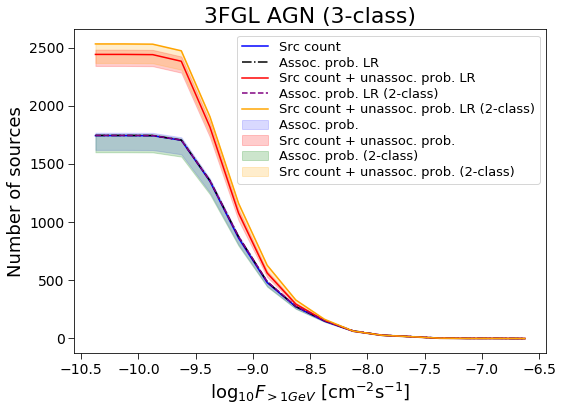

In [119]:
plot = pyplot.plot

add_2class = True

pyplot.figure()
plot(binsc, assoc_class_counts, c='blue', ls='-', label='Src count')
plot(binsc, class_dNdS[alg0], c='black', ls='-.', label='Assoc. prob. %s' % alg0)
minvs, maxvs = aux.min_max_vs(class_dNdS)
pyplot.fill_between(binsc, minvs, maxvs, color='blue', alpha=0.15, label='Assoc. prob.')


plot(binsc, assoc_class_counts + unas_dNdS[alg0], 
                c='red', ls='-', label='Src count + unassoc. prob. %s' % alg0)

minvs, maxvs = aux.min_max_vs(unas_dNdS)
pyplot.fill_between(binsc, assoc_class_counts + minvs, assoc_class_counts + maxvs, 
                    color='red', alpha=0.2, label='Src count + unassoc. prob.')

if add_2class:
    if pop != 'OTHER':
        xs = assoc_dNdS_2class['xs']
        plot(xs, assoc_dNdS_2class[alg0], c='purple', ls='--', label='Assoc. prob. %s (2-class)' % alg0)
    
    if pop != 'OTHER':
        label = 'Src count + unassoc. prob. %s (2-class)' % alg0
    else:
        label = 'Src count + unassoc. model (2-class)'
        
    xs = unas_dNdS_2class['xs']
    plot(xs, assoc_class_counts + unas_dNdS_2class[alg0], c='orange', ls='-', label=label)

    if pop != 'OTHER':
        minvs, maxvs = aux.min_max_vs(assoc_dNdS_2class, keys=algs)
        xs = assoc_dNdS_2class['xs']
        pyplot.fill_between(xs, minvs, maxvs, 
                            color='green', alpha=0.2, label='Assoc. prob. (2-class)')
    
        minvs, maxvs = aux.min_max_vs(unas_dNdS_2class, keys=algs)
        xs = unas_dNdS_2class['xs']
        pyplot.fill_between(xs, assoc_class_counts + minvs, assoc_class_counts + maxvs, 
                            color='orange', alpha=0.2, label='Src count + unassoc. prob. (2-class)')


pyplot.xlabel(r'$\log_{10} F_{>1 GeV}\ [\rm cm^{-2}s^{-1}]$')
pyplot.ylabel('Number of sources')
pyplot.legend(fontsize=13, labelspacing=0.2)

title = '%s %s (3-class)' % (cat_name, pop)
pyplot.title(title)

if pop == 'PSR':
    if cat == '3FGL':
        pyplot.ylim(-20, 600)
    else:
        pyplot.ylim(-1050/30, 1050)
elif pop == 'OTHER':
    if cat == '3FGL':
        pyplot.ylim(-15, 450)
    else:
        pyplot.ylim(-1050/30, 1050)

if save_plots:
    figfn = '../ML_3FGL_paper/plots/N_logS_%s_%s_3classes.pdf' % (cat_name, pop)
    print('Save figure to file:', figfn)
    pyplot.savefig(figfn)


In [120]:
#print(pop)
pred = [unas_dNdS[alg][0] for alg in algs]
#unas_dNdS
#print(pred)
mean, delta_plus, delta_minus = aux.get_mean_dp_dm(pred)
print('Number of %s (3-class): $%.1f^{+%.1f}_{-%.1f}$' % (pop, mean, delta_plus, delta_minus))
pred = [unas_dNdS_2class[alg][0] for alg in algs]
mean, delta_plus, delta_minus = aux.get_mean_dp_dm(pred)
print('Number of %s (2-class F-bin corrected): $%.1f^{+%.1f}_{-%.1f}$' % (pop, mean, delta_plus, delta_minus))

Number of AGN (3-class): $664.0^{+74.9}_{-65.2}$
Number of AGN (2-class F-bin corrected): $717.3^{+70.8}_{-92.7}$


In [121]:
# model for the number of other sources among unassociated ones
unas_dNdS_other_2class = {}
for alg in algs:
    unas_dNdS_other_2class[alg] = 0.
for pop_loc in ['PSR', 'AGN']:
    fn = 'data/section6_plots/%s_%s_unassoc_other.yaml' % (cat_name, pop_loc)
    unas_dNdS_other_2class0 = dio.loaddict(fn)
    for alg in algs:
        unas_dNdS_other_2class[alg] += np.array(unas_dNdS_other_2class0[alg])

print('N other model %s: %.1f' % (cat, np.sum(unas_dNdS_other_2class[alg0])))
# test
#for alg in algs:
#    print(np.sum(unas_dNdS_other_2class[alg]))

N other model 3FGL: 41.1
